# Quick Start

In this comprehensive quick start, we will build a support chatbot in LangGraph that can:

- Answer common questions by searching the web
- Maintain conversation state across calls
- Route complex queries to a human for review
- Use custom state to control its behavior
- Rewind and explore alternative conversation paths

We'll start with a basic chatbot and progressively add more sophisticated capabilities, introducing key LangGraph concepts along the way.

## Setup

First, install the required packages:

In [ ]:
%%capture --no-stderr
!pip install langchain langchain-google-genai langgraph

In [ ]:
from google.colab import userdata
GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI (
  api_key=GEMINI_API_KEY, model="gemini-1.5-flash")

In [ ]:
llm.invoke("Hi")


AIMessage(content='Hi there! What can I do for you today? \n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-125e635f-8b7a-4540-802a-235579814b19-0', usage_metadata={'input_tokens': 2, 'output_tokens': 12, 'total_tokens': 14})

## Start Building Chatbot using LangGraph

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.graph.state import CompiledStateGraph

class State(TypedDict):
  messages: Annotated[list,add_messages]


In [ ]:
def chatbot(state:State) -> State:
  return {"messages": llm.invoke(state["messages"])}

In [ ]:
builder : StateGraph = StateGraph(State)
# create chatbot Node
builder.add_node("chatbot", chatbot)
# create edge
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

In [ ]:
graph : CompiledStateGraph = builder.compile()

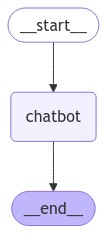

In [ ]:
from IPython.display import display, Image
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [ ]:
graph.invoke({"messages": ["what you know about Nawaz Sharif"]})

{'messages': [HumanMessage(content='what you know about Nawaz Sharif', additional_kwargs={}, response_metadata={}, id='19d1737e-c2de-43cf-9534-e590e3ba21c8'),
  AIMessage(content="## Nawaz Sharif: A Controversial Figure in Pakistani Politics\n\nNawaz Sharif is a prominent figure in Pakistani politics, having served as Prime Minister three times (1990-93, 1997-99, and 2013-17). He is a controversial figure, known for his political acumen and economic reforms, but also for his involvement in corruption scandals and political turmoil.\n\n**Here's a breakdown of key aspects of his life and career:**\n\n**Early Life and Career:**\n\n* Born in 1949 in Lahore, Pakistan, into a wealthy business family.\n* Entered politics in the 1980s, joining the Pakistan Muslim League (PML).\n* Became Chief Minister of Punjab province in 1985, a position he held until 1990.\n\n**Prime Ministerships:**\n\n* **1990-93:** First time as Prime Minister, focused on economic reforms, including privatization and der

In [ ]:
from threading import Event
from pprint import pprint
while True:
  user_input = input("Enter your message: ")
  if user_input.lower() in ["exit", "quit"]:
    pprint("Good Bye...")
    break
  for event in graph.stream({"messages": ("user",user_input)}):
    pprint(event.values())
    for value in event.values():
      pprint(value["messages"])
      print("Assistant: ",value["messages"].content)



Enter your message: how are you Abu Bakar
dict_values([{'messages': AIMessage(content="As an AI, I don't have a name or personal experiences like Abu Bakar.  \n\nIf you're looking for information about Abu Bakr, the first caliph of Islam, I can provide you with some details. \n\nWhat would you like to know about him? \n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-4e184e11-dc70-4b2f-b933-98784d7cf96c-0', usage_metadata={'input_tokens': 6, 'output_tokens': 58, 'total_tokens': 64})}])
AIMessage(content="As an AI